<a href="https://www.kaggle.com/code/gonzalogrecco144/house-price-regression?scriptVersionId=103163985" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import norm, boxcox
from scipy.special import inv_boxcox
import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from xgboost import XGBRegressor


### LOAD DATA 

In [2]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

train.drop('Id', axis=1, inplace=True)
id = test['Id']
test.drop('Id', axis=1, inplace=True)

print(train.shape)
print(test.shape)
print(train.head())

(1460, 80)
(1459, 79)
   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD   

### DATA DESCRIPTION

In [3]:
with open('../input/house-prices-advanced-regression-techniques/data_description.txt', 'r') as f:
    data = f.read()
# print(data)

### CORRELATION DATA 

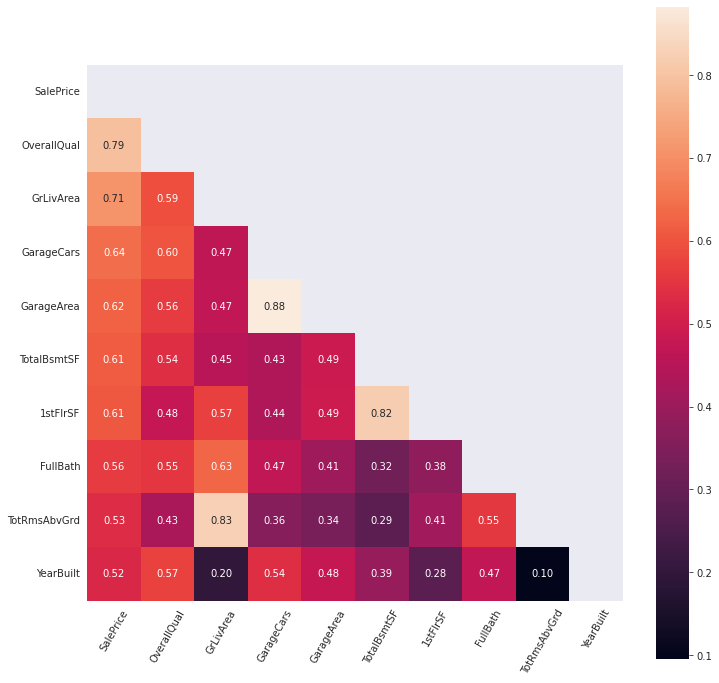

In [4]:
cols = train.corr().nlargest(10, 'SalePrice').index
corr_mat = np.corrcoef(train[cols].values.T)
fig = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_mat, annot = True, fmt = '.2f', square=True, 
            xticklabels=cols.values, yticklabels=cols.values,
            mask = np.triu(corr_mat))
plt.xticks(rotation=60)
plt.show()

### LOOKING FOR OUTLIERS

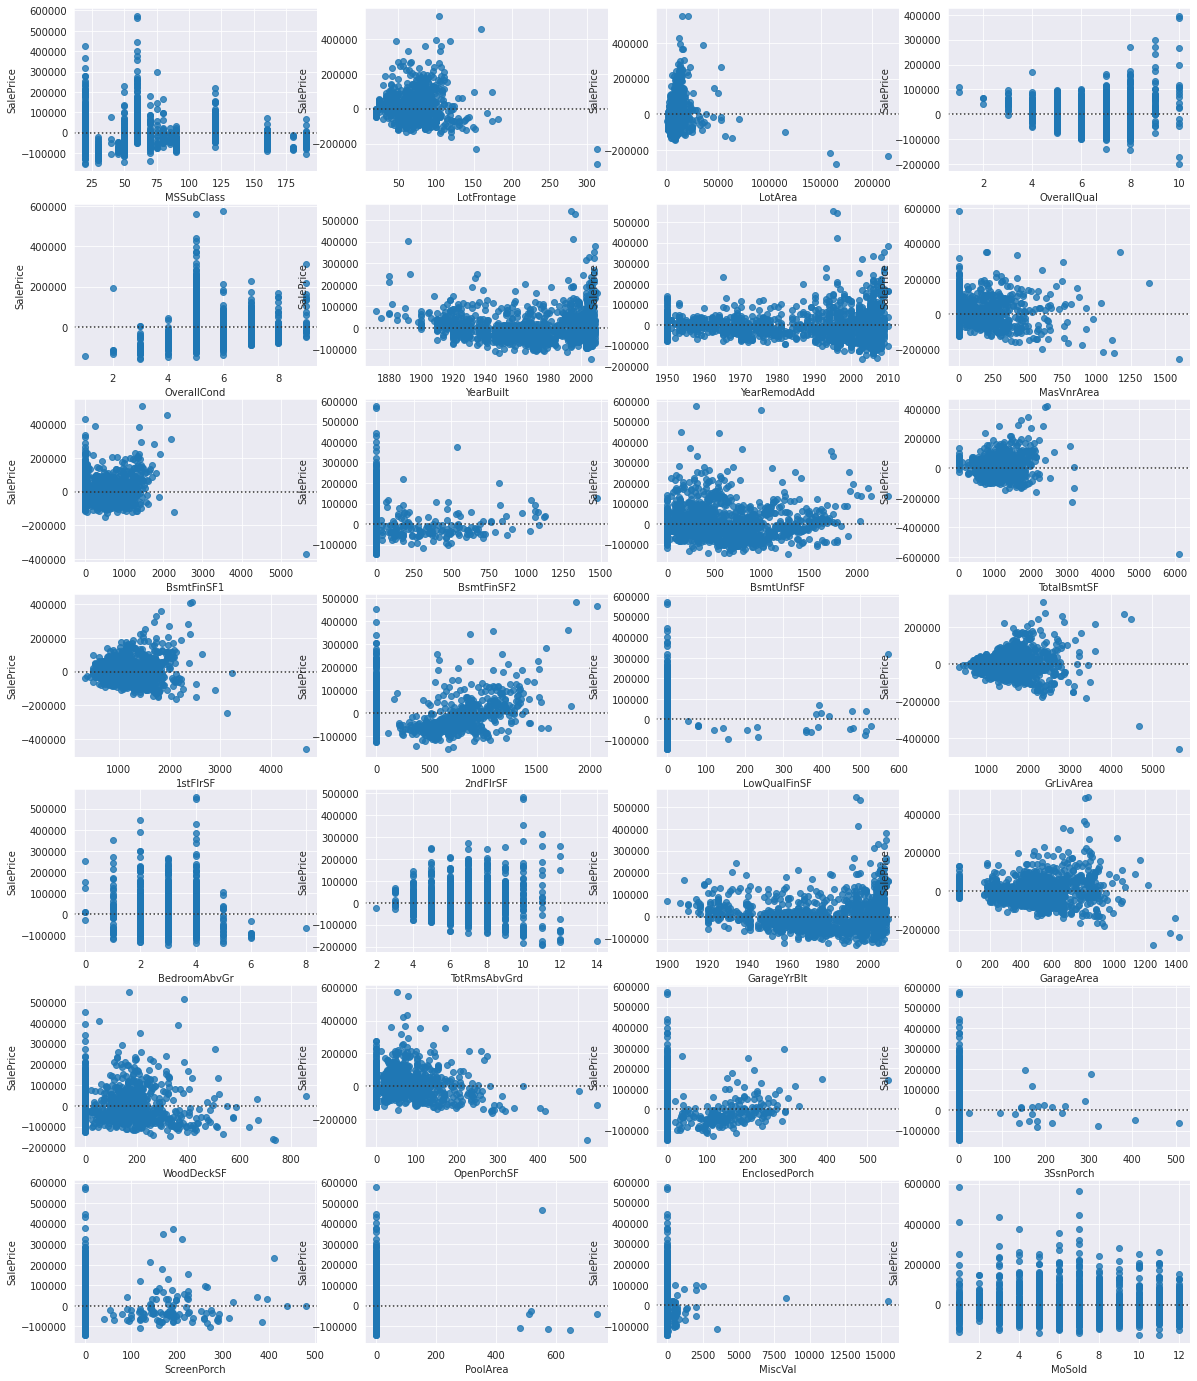

In [5]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for col in train:
    if train[col].dtype in numeric_dtypes:
        if train[col].value_counts().count() < 6 or col in ['SalePrice']:
            pass
        else:
            numeric.append(col)
fig, axs = plt.subplots(figsize=(20, 100))
for i, feature in enumerate(list(train[numeric]), 1):
    plt.subplot(len(list(numeric)), 4, i)
    sns.residplot(x=feature, y='SalePrice', data=train)
plt.show()

### REMOVING OUTLIERS

In [6]:
train.drop(train[train['BsmtFinSF1'] > 5000].index, inplace=True)
train.drop(train[(train['OverallQual'] < 5) & (train['SalePrice'] > 200000)].index, inplace=True)

### TARGET FEATURE 

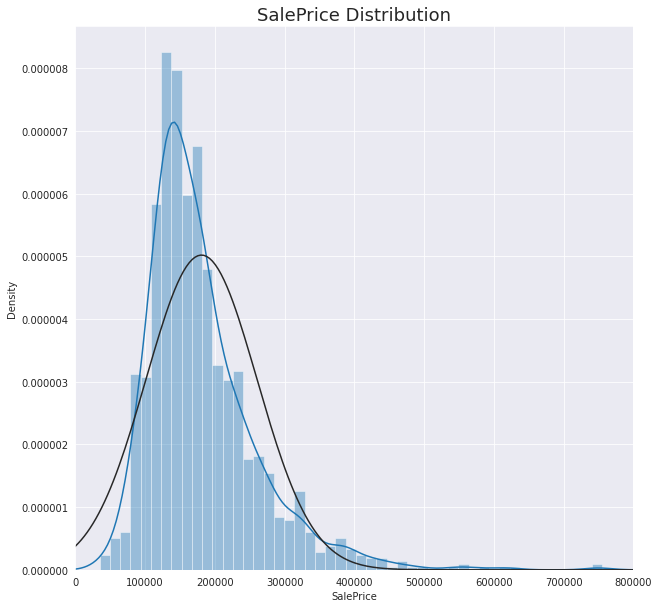

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.distplot(train['SalePrice'], fit=norm)
ax.set_title('SalePrice Distribution', fontsize=18)
ax.set(xlim=(0, 800000))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

skewness = train.SalePrice.skew()
kurtosis = train.SalePrice.kurt()

### SKEWNESS AND KURTOSIS

In [8]:
skewness = train.SalePrice.skew()
kurtosis = train.SalePrice.kurt()
print(f'Skewness of target feature: {skewness}')
print(f'Kurtosis of target feature: {kurtosis}')

Skewness of target feature: 1.884289599631205
Kurtosis of target feature: 6.538815206864026


### CORRECTING SKEWNESS

In [9]:
train['SalePrice1'] = np.log1p(train['SalePrice'])
print(f'Skewness with log(x+1): {train.SalePrice1.skew()}')
train['SalePrice2'] = np.log(train['SalePrice'])
print(f'Skewness with log: {train.SalePrice2.skew()}')
train['SalePrice3'] = np.sqrt(train['SalePrice'])
print(f'Skewness with sqrt: {train.SalePrice3.skew()}')
train['SalePrice4'] = boxcox(train['SalePrice'])[0]
lambda_value = boxcox(train['SalePrice'])[1]
print(f'Skewness with boxcox: {train.SalePrice4.skew()}')

Skewness with log(x+1): 0.12255928941766242
Skewness with log: 0.12254772839053264
Skewness with sqrt: 0.944572710500301
Skewness with boxcox: -0.008744744626077558


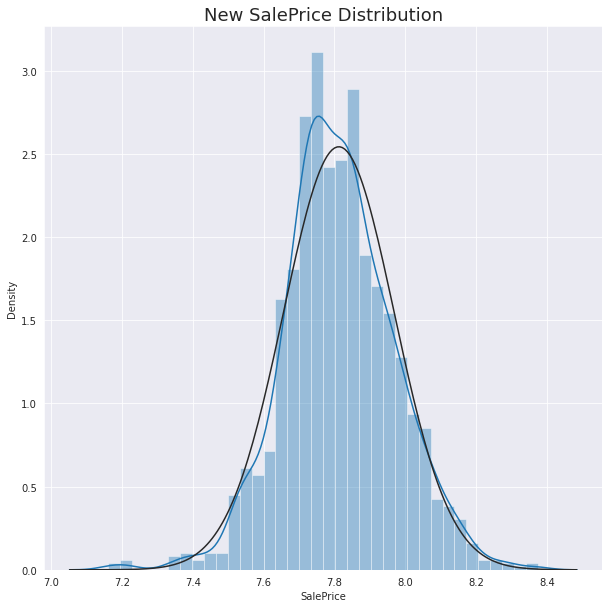

In [10]:
train['SalePrice'] = train['SalePrice4']
train.drop(['SalePrice1', 'SalePrice2', 'SalePrice3', 'SalePrice4'], axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.distplot(train['SalePrice'], fit = norm)
ax.set_title('New SalePrice Distribution', fontsize=18)
plt.show()

### NEW SKEWNESS AND KURTOSIS

In [11]:
print(f'New skewness of target feature: {train.SalePrice.skew()}')
print(f'New kurtosis of target feature: {train.SalePrice.kurt()}')

New skewness of target feature: -0.008744744626077558
New kurtosis of target feature: 0.8787915221481146


### COMBINING SETS

In [12]:
train_features = train.drop(['SalePrice'], axis=1)
all_data = pd.concat([train_features, test]).reset_index(drop=True)
all_data.shape

(2917, 79)

### MISSING VALUES

In [13]:
total = all_data.isnull().sum().sort_values(ascending=False)
percent = round((total / all_data.isnull().count() * 100).sort_values(ascending=False), 2)
missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
print(missing_data[missing_data['total'] > 0])

              total  percent
PoolQC         2908    99.69
MiscFeature    2812    96.40
Alley          2719    93.21
Fence          2346    80.43
FireplaceQu    1420    48.68
LotFrontage     485    16.63
GarageYrBlt     159     5.45
GarageFinish    159     5.45
GarageQual      159     5.45
GarageCond      159     5.45
GarageType      157     5.38
BsmtExposure     82     2.81
BsmtCond         82     2.81
BsmtQual         81     2.78
BsmtFinType2     80     2.74
BsmtFinType1     79     2.71
MasVnrType       24     0.82
MasVnrArea       23     0.79
MSZoning          4     0.14
Functional        2     0.07
BsmtHalfBath      2     0.07
BsmtFullBath      2     0.07
Utilities         2     0.07
SaleType          1     0.03
BsmtFinSF1        1     0.03
KitchenQual       1     0.03
GarageCars        1     0.03
BsmtUnfSF         1     0.03
TotalBsmtSF       1     0.03
Exterior2nd       1     0.03
Exterior1st       1     0.03
GarageArea        1     0.03
Electrical        1     0.03
BsmtFinSF2    

### TREATING MISSING DATA

In [14]:
all_data['PoolQC'].fillna('No pool', inplace=True)
all_data['Alley'].fillna('No alley access', inplace=True)
all_data['Electrical'].fillna('sBrkr', inplace = True)
all_data['LotFrontage'].fillna(all_data.LotFrontage.mean(), inplace=True)
all_data['Fence'].fillna('No Fence', inplace=True)

for column in ['MiscFeature', 'MasVnrType', 'FireplaceQu']:
    all_data[column].fillna('None', inplace=True)

for column in ['GarageType', 'GarageQual', 'GarageCond', 'GarageFinish']:
    all_data[column].fillna('No garage', inplace = True)

for column in ['BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']:
    all_data[column].fillna('No Basement', inplace = True)

for column in ['BsmtHalfBath', 'BsmtFullBath', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 
               'GarageCars', 'MasVnrArea', 'GarageArea', 'BsmtUnfSF', 'GarageYrBlt']:
    all_data[column].fillna(0, inplace=True)

for column in ['SaleType', 'Functional', 'KitchenQual', 'Exterior2nd',
               'Exterior1st', 'Utilities', 'MSZoning']:
    all_data[column].fillna(all_data[column].value_counts().index.tolist()[0], inplace=True)    

### CREATING NEW FEATURES

In [15]:
all_data['HasPool'] = (all_data['PoolQC'] != 'No pool') * 1
all_data['HasMiscFeature'] = (all_data['MiscFeature'] != 'None') * 1
all_data['HasAlleyAccess'] = (all_data['Alley'] != 'No alley access') * 1
all_data['HasFence'] = (all_data['Fence'] != 'No Fence') * 1
all_data['HasEnclosedPorch'] = (all_data['EnclosedPorch'] == 0) * 1
all_data['HasOpenPorch'] = (all_data['OpenPorchSF'] == 0) * 1
all_data['Has3SsnPorch'] = (all_data['3SsnPorch'] == 0) * 1
all_data['HasScreenPorch'] = (all_data['ScreenPorch'] == 0) * 1
all_data['HasFireplace'] = (all_data['FireplaceQu'] != 'None') * 1
all_data['HasGarage'] = (all_data['GarageType'] != 'No garage') * 1
all_data['HasBasement'] = (all_data['BsmtExposure'] != 'No Basement') * 1
all_data['HasWoodDeck'] = (all_data['WoodDeckSF'] == 0) * 1

### TRANSFORMING FEATURES

In [16]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

### CORRECTING SKEWNESS OF NUMERICAL FEATURES 

In [17]:
for col in all_data.columns:
    if all_data[col].dtype in numeric_dtypes:
        all_data[col] = np.log1p(all_data[col])

### ENCODING CATEGORICAL VALUES

In [18]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 344)


### SPLITING DATA

In [19]:
x = all_data.iloc[:len(train), :]
test = all_data.iloc[len(train):, :]
y = train["SalePrice"].values
print(x.shape, test.shape, y.shape)

(1458, 344) (1459, 344) (1458,)


## TRAINING A MODEL

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

### LINEAR REGRESSION

In [21]:
lin = LinearRegression(n_jobs = -1)
lin.fit(x, y)
y_pred = lin.predict(x_test)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred))
lin_score = lin.score(x_test, y_test)
print("The Root Mean Squared Error for Linear Regression is:", round(rmse_lin, 3))
print("Linear Regression Score is:", round(lin_score * 100, 3), "%")

The Root Mean Squared Error for Linear Regression is: 0.035
Linear Regression Score is: 95.845 %


### RIDGE REGRESSION

In [22]:
ridge = Ridge(alpha = 5)
ridge.fit(x, y)
y_pred = ridge.predict(x_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
ridge_score = ridge.score(x_test, y_test)
print("The Root Mean Squared Error for Ridge Regression is:", round(rmse_ridge, 3))
print("Ridge Regression Score is:", round(ridge_score * 100, 3), "%")

The Root Mean Squared Error for Ridge Regression is: 0.038
Ridge Regression Score is: 95.046 %


### LASSO REGRESSION

In [23]:
lasso = Lasso(alpha = 0.001)
lasso.fit(x, y)
y_pred = lasso.predict(x_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))
lasso_score = lasso.score(x_test, y_test)
print("The Root Mean Squared Error for Lasso Regression is:", round(rmse_lasso, 3))
print("Lasso Regression Score is:", round(lasso_score * 100, 3), "%")

The Root Mean Squared Error for Lasso Regression is: 0.046
Lasso Regression Score is: 92.568 %


### SUPPORT VECTOR REGRESSION

In [24]:
svr = SVR(kernel = 'rbf', gamma = 'scale', epsilon = 0.01, C = 1)
svr.fit(x, y)
y_pred = svr.predict(x_test)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred))
svr_score = svr.score(x_test, y_test)
print("The Root Mean Squared Error for Support Vector Regression is:", round(rmse_svr, 3))
print("Support Vector Regression Score is:", round(svr_score * 100, 3), "%")

The Root Mean Squared Error for Support Vector Regression is: 0.037
Support Vector Regression Score is: 95.238 %


### DECISION TREE REGRESSION

In [25]:
dtr = DecisionTreeRegressor(random_state = 0, max_depth = 6, max_leaf_nodes = 18,
                            min_samples_leaf = 9, splitter = 'best')
dtr.fit(x, y)
y_pred = dtr.predict(x_test)
rmse_dtr = np.sqrt(mean_squared_error(y_test, y_pred))
dtr_score = dtr.score(x_test, y_test)
print("The Root Mean Squared Error for Decision Tree Regression is:", round(rmse_dtr, 3))
print("Decision Tree Regression Score is:", round(dtr_score * 100, 3), "%")

The Root Mean Squared Error for Decision Tree Regression is: 0.069
Decision Tree Regression Score is: 83.62 %


### RANDOM FOREST REGRESSION

In [26]:
rfr = RandomForestRegressor(n_estimators = 130, max_depth = 6, min_samples_split = 2)
rfr.fit(x, y)
y_pred = rfr.predict(x_test)
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred))
rfr_score = rfr.score(x_test, y_test)
print("The Root Mean Squared Error for Random Forest Regression is:", round(rmse_rfr, 3))
print("Random Forest Regression Score is:", round(rfr_score * 100, 3), "%")

The Root Mean Squared Error for Random Forest Regression is: 0.041
Random Forest Regression Score is: 94.036 %


### ADABOOST REGRESSOR

In [27]:
abr = AdaBoostRegressor(random_state = 0, learning_rate = 0.1, n_estimators = 300)
abr.fit(x, y)
y_pred = abr.predict(x_test)
rmse_abr = np.sqrt(mean_squared_error(y_test, y_pred))
abr_score = abr.score(x_test, y_test)
print("The Root Mean Squared Error is:", round(rmse_abr, 3))
print("ABR Score is:", round(abr_score * 100, 3), "%")

The Root Mean Squared Error is: 0.062
ABR Score is: 86.679 %


### XGBOOST REGRESSOR

In [28]:
xgb = XGBRegressor(n_estimators = 990, learning_rate = 0.02)
xgb.fit(x, y)
y_pred = xgb.predict(x_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_score = xgb.score(x_test, y_test) 
print("The Root Mean Squared Error is:", round(rmse_xgb, 4))
print("XGB Score is:", round(xgb_score * 100, 3), "%")

The Root Mean Squared Error is: 0.0097
XGB Score is: 99.673 %


### VISUALIZING RESULTS

In [29]:
data = {'Linear Regression': (rmse_lin, lin_score), 'Ridge Regression': (rmse_ridge, ridge_score), 
        'Lasso Regression': (rmse_lasso, lasso_score), 'Support Vector Regression': (rmse_svr, svr_score),
       'Decision Tree Regression': (rmse_dtr, dtr_score), 'Random Forest Regression': (rmse_rfr, rfr_score),
       'AdaBoost Regression': (rmse_abr, abr_score), 'XGBoost Regressor': (rmse_xgb, xgb_score)}

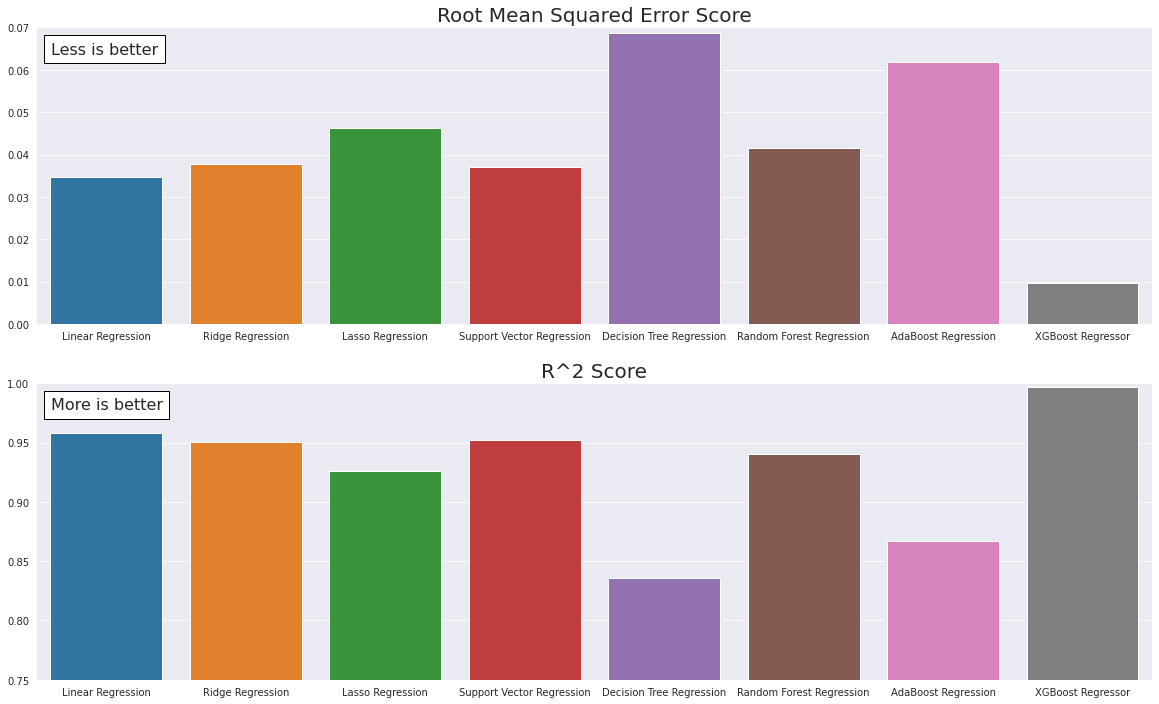

In [30]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 12))
models = list(data.keys())
values = list(data.values())
rmse_values = [value[0] for value in values]
score_values = [value[1] for value in values]
ax0 = sns.barplot(x = models, y = rmse_values, ax=ax0)
ax0.set_ylim(0, 0.07)
ax0.set_title('Root Mean Squared Error Score',size=20)
at0 = AnchoredText('Less is better', prop=dict(size=16), loc='upper left')
ax0.add_artist(at0)
ax1 = sns.barplot(x = models, y = score_values, ax=ax1)
ax1.set_ylim(0.75, 1)
ax1.set_title('R^2 Score', size=20)
at1 = AnchoredText('More is better', prop=dict(size=16), loc='upper left')
ax1.add_artist(at1)
plt.show()

### SUBMIT PREDICTION

In [31]:
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.shape
submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [32]:
prediction = xgb.predict(test)
submission.iloc[:, 1] = np.floor(inv_boxcox(prediction, lambda_value))
submission.head()

,Id,SalePrice
0,1461,122379.0
1,1462,164783.0
2,1463,187376.0
3,1464,191193.0
4,1465,187011.0


In [33]:
q1 = submission['SalePrice'].quantile(0.06)
q2 = submission['SalePrice'].quantile(0.95)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*1.75)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*0.4)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < 250000 else x-75000)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > 135000 else x+55000)

submission.to_csv('submission_prediction', index=False)